<a href="https://colab.research.google.com/github/LoniQin/lifelong-ml/blob/main/HayStack_Branching_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HayStack Branching Pipeline
The goal is to create a system that first tries to answer questions using a pre-indexed knowledge base. If no answer is found, it seamlessly transitions to web search for broader knowledge.


## Step 1: Environment Setup:
Install necessary libraries (Haystack, Trafilatura) and set up API keys for Gemini, Cohere, and a web search provider (like Serper).

In [1]:
!pip install -q google-ai-haystack trafilatura

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.8/207.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.8/131.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 837.8/837.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.7/350.7 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.9/362.9 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4

In [17]:
from haystack.components.routers import ConditionalRouter
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever
from haystack.components.websearch.serper_dev import SerperDevWebSearch
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack import Document, Pipeline, component
from haystack.utils.auth import Secret
from haystack.components.converters import HTMLToDocument
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.writers import DocumentWriter
from haystack_integrations.components.generators.google_ai import GoogleAIGeminiGenerator
from haystack.dataclasses import ChatMessage
from typing import List
from google.colab import userdata
import requests
import os
# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
CO_API_KEY = userdata.get('CO_API_KEY')
SERPER_API_KEY = userdata.get('SERPER_API_KEY')
os.environ['CO_API_KEY'] = CO_API_KEY
os.environ["GOOGLE_API_KEY"] = GEMINI_API_KEY
os.environ["SERPERDEV_API_KEY"] = SERPER_API_KEY

### Step 2: Index Documents into InMemoryDocumentStore
* Create Document objects representing your knowledge base entries.
* Initialize an InMemoryDocumentStore and store these documents.

In [4]:
documents = [Document(content="Retrievers: Retrieves relevant documents to a user query using keyword search or semantic search."),
             Document(content="Embedders: Creates embeddings for text or documents."),
             Document(content="Generators: Use a number of model providers to generate answers or content based on a prompt"),
             Document(content="File Converters: Converts different file types like TXT, Markdown, PDF, etc. into a Haystack Document type")]

document_store = InMemoryDocumentStore()
document_store.write_documents(documents=documents)

4

### Step 3: Create RAG Pipeline

* Define a prompt template to guide Gemini in answering questions based on the knowledge base.
* Build a pipeline with:
  * InMemoryBM25Retriever to retrieve relevant documents.
  * PromptBuilder to construct prompts using the template.
  * GoogleAIGeminiGenerator as the LLM to generate answers.

In [5]:
rag_prompt_template = """
Answer the following query given the documents.
If the answer is not contained within the documents, reply with 'no_answer'
Query: {{query}}
Documents:
{% for document in documents %}
  {{document.content}}
{% endfor %}
"""

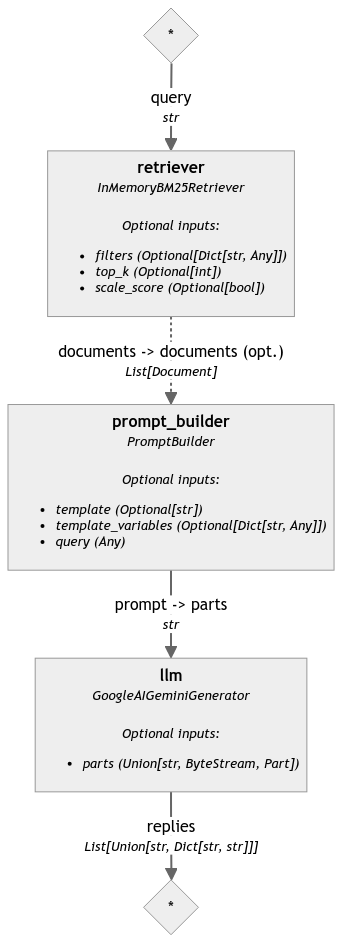

In [7]:
rag = Pipeline()
rag.add_component("retriever", InMemoryBM25Retriever(document_store=document_store))
rag.add_component("prompt_builder", PromptBuilder(template=rag_prompt_template))
rag.add_component("llm", GoogleAIGeminiGenerator(model="gemini-1.5-flash"))

rag.connect("retriever.documents", "prompt_builder.documents")
rag.connect("prompt_builder", "llm")
rag.show()

In [8]:
query = "What is a retriever for?"

rag.run({"prompt_builder":{"query": query},
         "retriever": {"query": query}})

{'llm': {'replies': ['Retrievers are used to **retrieve relevant documents to a user query using keyword search or semantic search**. \n']}}

In [9]:
query = "What Mistral components are there?"

rag.run({"prompt_builder":{"query": query},
         "retriever": {"query": query}})

{'llm': {'replies': ['no_answer \n']}}

### Step 4. Conditional Routing:

* Implement a ConditionalRouter to analyze Gemini's responses.
* If the response indicates no answer was found in the knowledge base, route the query to the web search branch.
* Otherwise, directly output the answer provided by Gemini.

In [10]:
routes = [
    {
        "condition": "{{'no_answer' in replies[0]|lower}}",
        "output": "{{query}}",
        "output_name": "go_to_websearch",
        "output_type": str,
    },
    {
        "condition": "{{'no_answer' not in replies[0]|lower}}",
        "output": "{{replies[0]}}",
        "output_name": "answer",
        "output_type": str,
    },
]

In [11]:
router = ConditionalRouter(routes=routes)
router.run(replies=['Geoff is my friend'], query="Who is Geoff?")

{'answer': 'Geoff is my friend'}

In [12]:
router.run(replies=['No_answer'], query="Who is Geoff?")

{'go_to_websearch': 'Who is Geoff?'}

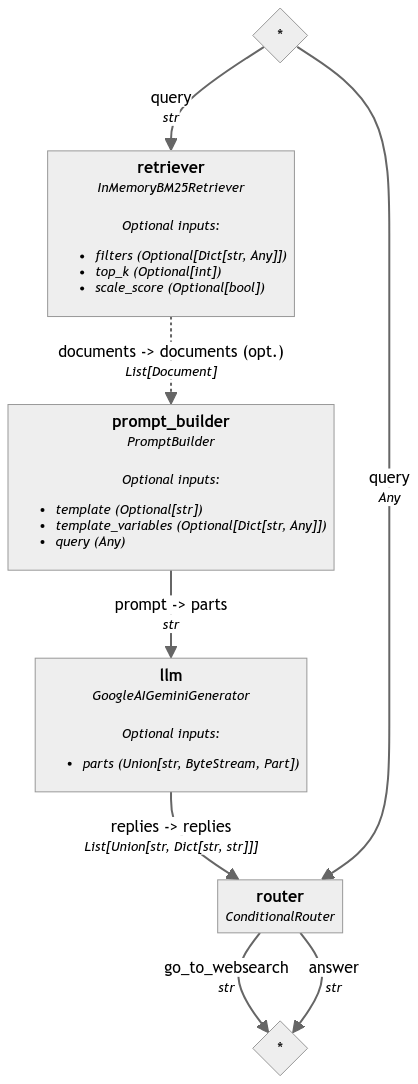

In [13]:
rag.add_component("router", ConditionalRouter(routes=routes))
rag.connect("llm.replies", "router.replies")

rag.show()

In [14]:
query = "What Mistral components does Haystack have?"

rag.run({"prompt_builder":{"query": query},
         "retriever": {"query": query},
         "router": {"query": query}})

{'router': {'go_to_websearch': 'What Mistral components does Haystack have?'}}

### Step 5. Web Search Branch:
* Add a web search component (e.g., `SerperDevWebSearch`) to the pipeline.
* Define a prompt template to instruct Gemini on how to use web search results to answer the question.
* Include another PromptBuilder and `GoogleAIGeminiGenerator` for this branch.

In [15]:
prompt_for_websearch = """
Answer the following query given the documents retrieved from the web.
Your answer should indicate that your answer was generated from websearch.
You can also reference the URLs that the answer was generated from

Query: {{query}}
Documents:
{% for document in documents %}
  {{document.content}}
{% endfor %}
"""

### Step 6: Pipeline Connection
Connect all components in the pipeline, ensuring data flows correctly between retrieval, prompt building, LLM generation, routing, and the web search branch.

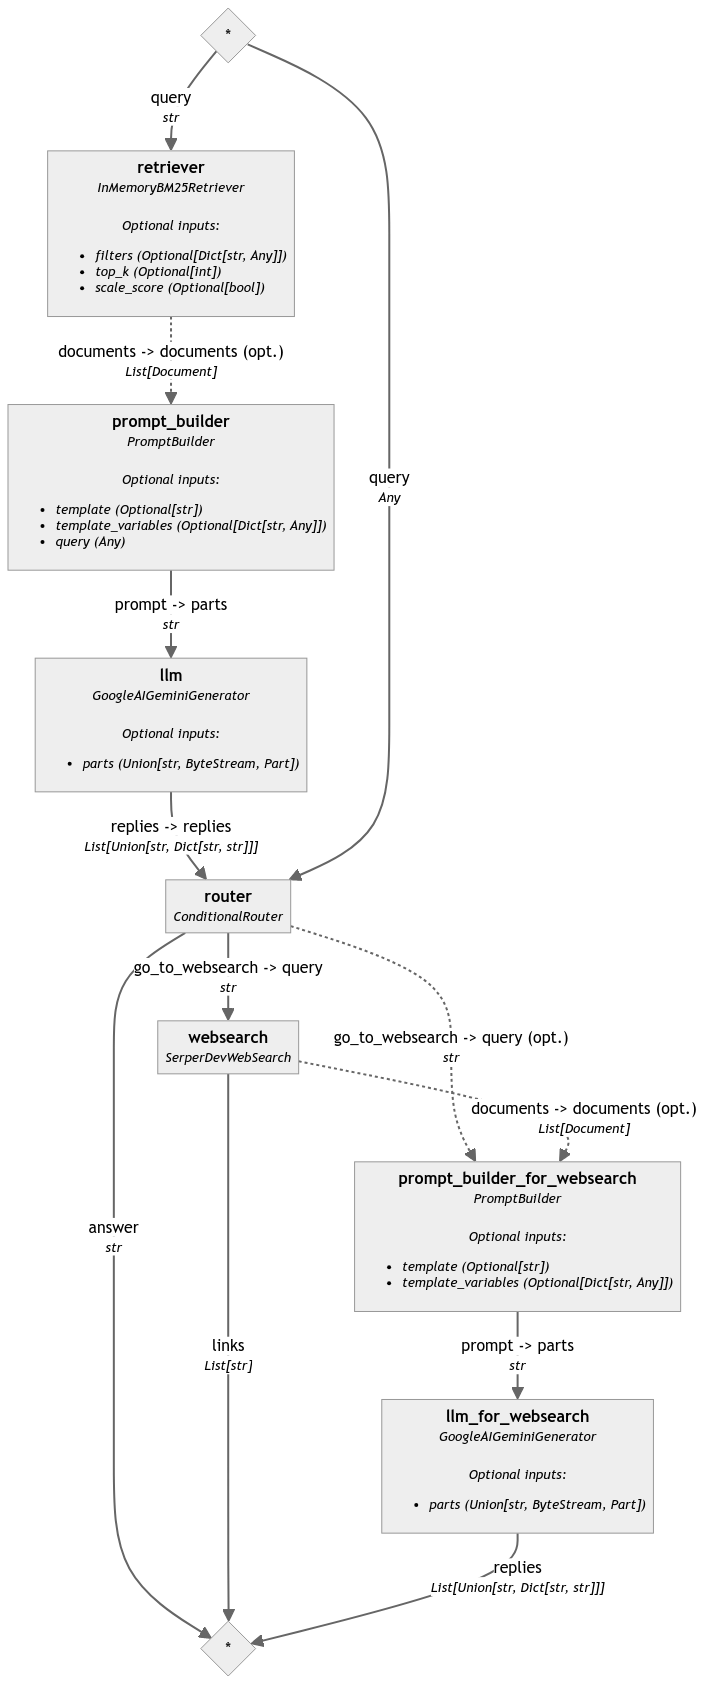

In [19]:
rag_or_websearch = Pipeline()
rag_or_websearch.add_component("retriever", InMemoryBM25Retriever(document_store=document_store))
rag_or_websearch.add_component("prompt_builder", PromptBuilder(template=rag_prompt_template))
rag_or_websearch.add_component("llm", GoogleAIGeminiGenerator(model="gemini-1.5-flash"))
rag_or_websearch.add_component("router", ConditionalRouter(routes))
rag_or_websearch.add_component("websearch", SerperDevWebSearch())
rag_or_websearch.add_component("prompt_builder_for_websearch", PromptBuilder(template=prompt_for_websearch))
rag_or_websearch.add_component("llm_for_websearch",  GoogleAIGeminiGenerator(model="gemini-1.5-flash"))

rag_or_websearch.connect("retriever", "prompt_builder.documents")
rag_or_websearch.connect("prompt_builder", "llm")
rag_or_websearch.connect("llm.replies", "router.replies")
rag_or_websearch.connect("router.go_to_websearch", "websearch.query")
rag_or_websearch.connect("router.go_to_websearch", "prompt_builder_for_websearch.query")
rag_or_websearch.connect("websearch.documents", "prompt_builder_for_websearch.documents")
rag_or_websearch.connect("prompt_builder_for_websearch", "llm_for_websearch")

rag_or_websearch.show()

## Step 7. Testing and Evaluation:

* Run various queries through the pipeline.
* Observe how the system handles questions answerable from the knowledge base versus those requiring web search.

In [20]:
query= "What is a retriever for?"

rag_or_websearch.run({"prompt_builder":{"query": query},
                      "retriever": {"query": query},
                      "router": {"query": query}})

{'router': {'answer': 'Retrievers are used to **retrieve relevant documents to a user query using keyword search or semantic search**. \n'}}

In [21]:
query = "What Mistral components does Haystack have?"

rag_or_websearch.run({"prompt_builder":{"query": query},
                      "retriever": {"query": query},
                      "router": {"query": query}})

{'websearch': {'links': ['https://haystack.deepset.ai/integrations/mistral',
   'https://docs.haystack.deepset.ai/reference/integrations-mistral',
   'https://github.com/deepset-ai/haystack-integrations/blob/main/integrations/mistral.md',
   'https://github.com/anakin87/mistral-haystack/blob/main/mistral_haystack.ipynb',
   'https://www.e2enetworks.com/blog/rag-implementation-using-mistral-7b-haystack-and-weaviate',
   'https://docs.mistral.ai/guides/rag/',
   'https://www.toolify.ai/ai-news/build-an-efficient-rag-model-with-haystack-and-mistral-7b-1476907',
   'https://khadkechetan.medium.com/information-extraction-with-mistral-8x7b-47111b8bd035',
   'https://www.restack.io/p/haystack-utilities-answer-cat-ai',
   'https://www.linkedin.com/posts/sonukr0_rag-implementation-using-mistral-7b-haystack-activity-7113868111451234304-Bv_s']},
 'llm_for_websearch': {'replies': ['Haystack currently has one Mistral component: **MistralDocumentEmbedder**. This component creates embeddings for Hays

In [22]:
query = "Who's the president of USA?"

rag_or_websearch.run({"prompt_builder":{"query": query},
                      "retriever": {"query": query},
                      "router": {"query": query}})

{'websearch': {'links': ['https://www.instagram.com/potus/?hl=en',
   'https://www.whitehouse.gov/administration/president-biden/',
   'https://usun.usmission.gov/our-leaders/the-president-of-the-united-states/',
   'https://www.facebook.com/POTUS/',
   'https://en.wikipedia.org/wiki/President_of_the_United_States',
   'https://www.whitehouse.gov/about-the-white-house/presidents/',
   'https://www.britannica.com/video/226766/who-is-President-Joe-Biden',
   'https://www.economist.com/interactive/us-2024-election/trump-harris-polls',
   'https://en.wikipedia.org/wiki/List_of_presidents_of_the_United_States',
   'https://www.ohiosos.gov/elections/election-results-and-data/historical-election-comparisons/presidents-of-the-united-states-of-america/']},
 'llm_for_websearch': {'replies': ['The current president of the United States is **Joe Biden**. \n\nThis information can be found in many of the provided documents, including:\n\n* [https://www.instagram.com/potus/](https://www.instagram.com

In [23]:
query = "Do you know the market value of Apple?"

rag_or_websearch.run({"prompt_builder":{"query": query},
                      "retriever": {"query": query},
                      "router": {"query": query}})

{'websearch': {'links': ['https://companiesmarketcap.com/apple/marketcap/',
   'https://www.marketwatch.com/investing/stock/aapl',
   'https://finance.yahoo.com/quote/AAPL/key-statistics/',
   'https://www.macrotrends.net/stocks/charts/AAPL/apple/market-cap',
   'https://ycharts.com/companies/AAPL/market_cap',
   'https://www.nasdaq.com/market-activity/stocks/aapl',
   'https://finance.yahoo.com/quote/AAPL/',
   'https://investor.apple.com/stock-price/default.aspx',
   'https://fortune.com/2023/06/30/apple-history-3-trillion-market-value/',
   'https://www.investopedia.com/news/apple-now-bigger-these-5-things/']},
 'llm_for_websearch': {'replies': ["According to information found online, Apple's market cap as of August 20, 2024 was $3,443.89 billion. [Source: https://www.marketbeat.com/stocks/NASDAQ/AAPL/market-cap/] \n"]}}

## Conclusion

This notebook demonstrated how to build a robust question-answering system using Haystack and Gemini. By leveraging a branching pipeline, the system intelligently combines a knowledge base with web search capabilities, ensuring a wider range of questions can be answered. The flexibility of Haystack components and the power of the Gemini LLM enable the creation of a system that can be tailored to specific needs. Experimenting with different retrievers, prompt templates, and LLM settings can further optimize performance and accuracy for your particular use case. This approach provides a solid foundation for building sophisticated question-answering applications that can adapt to diverse information needs.